In [1]:
!pip install pymongo
!pip install pycld2
!pip install pandas
!pip install nltk
!pip install redis

### mongodb caching

start redis server with the followin configuration in order to speed up the inverted index construction:

```
redis-server --maxmemory 10GB --maxmemory-policy allkeys-lfu --port 27018
```

In [2]:
from __future__ import print_function

import string
import re
import sys

import pycld2 as cld2

from multiprocessing.pool import Pool
from tqdm._tqdm_notebook import tqdm

from IPython.display import display, clear_output

import numpy as np
import pandas as pd

from os import getcwd, pardir
from os.path import join, basename

from utils.literature import DataLoader, get_document_title, is_english, get_section, get_sections, get_files, get_authors, get_paper_id
from utils.preprocessing import NLPPipeline, Tokenizer, Stemmer, ToLowercase, Lemmatizer, StopwordRemover, CitationRemover, SymbolRemover, ContentInBracketsRemover
from utils.grid.grid import GridLookup
from utils.metadata import CORDMetadata

from glob import glob

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer #TODO: Try lemmatizer instead of stemmer

import pymongo
from pymongo import MongoClient as DBClient

import redis

from collections import Counter

nltk.download()

## Specification of the document paths

- download from: [Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
- extract folder content to `{ProjectDir}/dataset`

In [3]:
root_dir = join(pardir, 'dataset')
files = get_files(root_dir)

## Building the document index

In [4]:
with DBClient('localhost', 27017, w=0) as client:
    db = client['covid_19']
    inverted_index_collection = db['inverted_index']
    inverted_index_collection.create_index([("doc_ids", pymongo.ASCENDING)], background=True, name='doc_ids')
    inverted_index_collection.create_index([("doc_ids.doc_id", pymongo.ASCENDING)], background=True, name='doc_ids.doc_id')

In [5]:
pipeline = NLPPipeline([
    ToLowercase(),
    CitationRemover(),
    ContentInBracketsRemover(),
    Tokenizer(),
    SymbolRemover(),
    StopwordRemover(),
    Stemmer()
])

In [6]:
def create_post(stem, doc_id, count_object):
    return {'_id': stem, 'doc_ids': [{'doc_id': doc_id, 'count': count_object}]}

In [7]:
def create_count_object(section, count=1):
    if section is 'title': return {'title': count, 'abstract': 0, 'body_text': 0}
    elif section is 'abstract': return {'title': 0, 'abstract': count, 'body_text': 0}
    elif section is 'body_text': return {'title': 0, 'abstract': 0, 'body_text': count}
    else: raise Exception('Invalid section')

In [8]:
def update_document_index(doc_id, document_title, document_index_collection):
    doc_id_entry = document_index_collection.find({'_id': doc_id}).limit(1)
    if doc_id_entry.count() == 0:
        document_index_collection.insert_one({'_id': doc_id, 'document_title': document_title})

In [9]:
def create_document_index_object(doc_id, document_title, authors, abstract, url):
    return {'_id': doc_id, 'document_title': document_title, 'abstract': abstract, 'authors': [{'author': author, 'institution': institution['Name'] 
    if institution != None else 'undefined'} for author, institution in authors], 'url': url}

In [10]:
def update_cache_stem(stem, redis_cache):
    redis_cache.set(stem, 'T')

In [11]:
def update_cache_doc_id(stem, doc_id, redis_cache):
    redis_cache.set(f'stem:{stem}_doc_id:{doc_id}', 'T')

In [12]:
def update_cache_document(title, redis_cache):
    redis_cache.set(title)

In [13]:
def is_document_existent(title, redis_cache):
    return True if redis_cache.get(title) else False

In [14]:
def is_stem_existent(stem, inverted_index_collection, redis_cache):
    result = redis_cache.get(stem)
    if result: return True

    result = inverted_index_collection.find({'_id': stem}).limit(1)
    return True if result.count() > 0 else False

In [15]:
def is_doc_id_existent(stem, doc_id, inverted_index_collection, redis_cache):
    result = redis_cache.get(f'stem:{stem}_doc_id:{doc_id}')
    if result: return True
    
    result = inverted_index_collection.find(
                {'_id': stem, 
                'doc_ids': {'$elemMatch': {'doc_id': doc_id}}}).limit(1)
    return True if result.count() > 0 else False

In [16]:
def update_inverted_index(doc_id, stemmed_tokens, section, inverted_index_collection, redis_cache):
    #update inverted index
    for stem, count in stemmed_tokens.items():
        has_stem = is_stem_existent(stem, inverted_index_collection, redis_cache)
        if has_stem:
            #try to find current document id in stem entry
            has_doc_id = is_doc_id_existent(stem, doc_id, inverted_index_collection, redis_cache)
            if has_doc_id:
                # update occurrence of stem in document section
                inverted_index_collection.update(
                    {'_id': stem, 
                    'doc_ids': {'$elemMatch': {'doc_id': doc_id}}},
                    {'$inc': {f'doc_ids.$.count.{section}': count}})
            else:
                # add document id
                update_cache_doc_id(stem, doc_id, redis_cache)
                inverted_index_collection.update(
                    {'_id': stem},
                    {'$push': {'doc_ids': {'doc_id': doc_id, 'count': create_count_object(section, count)}}})
        else:
            update_cache_stem(stem, redis_cache)
            post = create_post(stem, doc_id, create_count_object(section, count))
            inverted_index_collection.insert_one(post)

In [17]:
grid_lookup = GridLookup()
cord_metadata = CORDMetadata()

In [18]:
def process_chunk(chunk, update_doc_idx=True, update_inv_indx=True):
    with DBClient('localhost', 27017, w=0) as client:
        with redis.Redis(host='localhost', port=27018) as redis_cache:
            #open a connection to the database
            db = client['covid_19']
            document_index_collection = db['document_index']
            inverted_index_collection = db['inverted_index']

            document_objects = []
            
            #iterate over all documents in chunk
            for fpath, doc_id in chunk:
                doc_id = int(doc_id)
                data_loader = DataLoader(fpath, grid_lookup) #dummy object for grid lookup

                doc_title = get_document_title(fpath, data_loader)
                

                #database should only contain english documents with an valid document title
                if doc_title == '' or not is_english(doc_title):
                    continue

                if update_doc_idx:
                    abstract = get_section(fpath,'abstract', data_loader)[:500] + "..."
                    authors = get_authors(fpath, data_loader, plausibility_check=True, clean_names=True, normalize_names=False)
                    sha = get_paper_id(fpath, data_loader)
                    url = cord_metadata.get_document_url(sha)

                    document_index_collection.insert_one(create_document_index_object(doc_id, doc_title, authors, abstract, url))


                if not update_inverted_index:
                    continue
                
                for section in get_sections():
                    text = get_section(fpath, section, dl=data_loader)
                    stemmed_tokens = pipeline.transform(text)
                    stemmed_tokens_reduced = Counter(stemmed_tokens)
                    update_inverted_index(doc_id, stemmed_tokens_reduced, section, inverted_index_collection, redis_cache)

In [19]:
def create_chunks(files, chunk_size=128):
    doc_ids = list(range(len(files)))
    chunks = list()
    for i in range(0, len(files), chunk_size):
        indices = np.array(doc_ids[i: min(i+chunk_size, len(files))])
        chunks.append(list(zip(
            files[i: min(i+chunk_size, len(files))], 
            doc_ids[i: min(i+chunk_size, len(files))])))
    return chunks

In [20]:
pool = Pool()
chunks = create_chunks(files)

for _ in tqdm(pool.imap_unordered(process_chunk, chunks), total=len(chunks)):
    pass

pool.close()
pool.join()

## Performance monitoring

~ 20 0000 documents in database

Backlog: automatische Übersetzung
Neo4j semantic web

```py
%%timeit -n 100
with DBClient('localhost', 27017, w=0) as client:
    #open a connection to the database
    db = client['covid_19']
    document_index_collection = db['document_index']
    inverted_index_collection = db['inverted_index']
```

785 µs ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

```py
%%timeit -n 100
data_loader = DataLoader(files[0])
doc_title = get_document_title(files[0], data_loader)
```

496 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [21]:
%%timeit -n 100
data_loader = DataLoader(files[0])
abstract = get_section(files[0], 'abstract', data_loader)

```py
data_loader = DataLoader(files[0])
abstract = get_section(files[0], 'abstract', data_loader)

%%timeit -n 100
is_english(abstract)
```

48.8 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

```py
%%timeit -n 100
pipeline.transform(doc_title)
```

1.35 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

```py
%%timeit
inverted_index_collection.find({'_id': 'detect'}).limit(1).count()
```

1.35 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

```py
%%timeit
doc_id_object = inverted_index_collection.find(
                {'_id': 'detect', 
                'doc_ids': {'$elemMatch': {'doc_id': 312}}}).limit(1).count()
```

1.35 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

```py
import uuid

%%timeit
post = create_post(uuid.uuid4(), -1, count_object['abstract'])
inverted_index_collection.insert_one(post)
```

98.7 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

```py
%%timeit
inverted_index_collection.update(
        {'_id': 'testtoken', 
        'doc_ids': {'$elemMatch': {'doc_id': -1}}},
        {'$inc': {f'doc_ids.$.count.abstract': 1}})
```

99.2 µs ± 999 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

```py
%%timeit -n 1000
inverted_index_collection.update(
                    {'_id': 'testtoken'},
                    {'$push': {'doc_ids': {'doc_id': -2, 'count': count_object['abstract']}}})
```

99.2 µs ± 999 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

In [10]:
timings_db = pd.DataFrame()

timings_db['action'] = ["connection establishment", "read access", "write access"]
timings_db['timing'] = [0.785, 1.35, 0.096]

In [11]:
from matplotlib import pyplot as plt

In [12]:
import matplotlib.cm as cm

In [13]:
def f(df):
  groups = df.groupby('action')
  for i, (name,group) in enumerate(groups):
    plt.bar(name, group['timing'], label=name, align='center', color=cm.Blues(i*30 + 100))

  ax = plt.gca()
  #ax.get_xaxis().set_visible(False)
  ax.set_ylabel('Durchschnittliche Laufzeit in ms')
  ax.grid(linestyle=':')
  #plt.legend()
  fig = plt.gcf()
  fig.savefig('laufzeit-mongo.png', dpi=300)

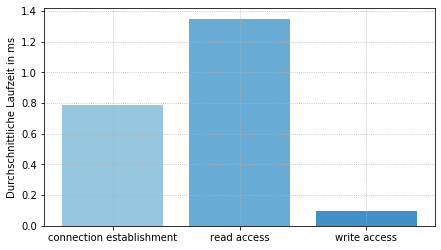

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 4
f(timings_db)